# Configuration

In [139]:
# Set the subject to work with (use the actual #, not the index)
subject_number = 1

# Set the percentage of subject data to use for train and test sets.
subject_data_percentage = 0.2

# Sequence Length (in seconds)
sequence_length = 1

# Set the predictive horizon (in seconds)
predictive_horizon = 1

assert subject_number > 0, "Subject number must be greater than 0."
assert subject_data_percentage > 0, "Subject data percentage must be greater than 0."
assert predictive_horizon > 0, "Predictive horizon must be greater than 0."
assert sequence_length > 0, "Sequence length must be greater than 0."

# Setup

In [140]:
# Imports
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt

In [141]:
# Constants
sequence_length = sequence_length * 100
predictive_horizon = predictive_horizon * 100

# Data Prep

### Import Data

In [142]:
# Read in files
files = glob.glob('data/ProcessedData_Subject*.csv')

data_dfs = []

for filepath in files:
    df = pd.read_csv(filepath)
    
    # Extract subject number from path
    current_subject_number = filepath.split('/')[-1].split('_Subject')[1].split('.')[0].lstrip('0')
    df['Subject Number'] = current_subject_number
    data_dfs.append(df)
    
    if str(current_subject_number) == str(subject_number): # Early exit condition since we're only running this for 1 subject
        break

# Check
#data_dfs[0].head()

### Clean Data

In [143]:
subject_df = data_dfs[subject_number - 1]

def remove_outliers(df, columns):
    z_scores = np.abs(stats.zscore(df[columns]))
    filtered_entries = (z_scores < 4).all(axis=1)  # Relaxing the threshold to 4
    return df[filtered_entries]

def standardize(df, columns):
    scaler = StandardScaler()
    df.loc[:, columns] = scaler.fit_transform(df[columns])
    return df

# Fill missing values with forward fill
subject_df.ffill(inplace=True)

# Define columns to process
columns_to_process = ['Pressure [cmH2O]', 'V_tidal [L]', 'Flow [L/s]']

subject_df_clean = remove_outliers(df, columns_to_process)

subject_df_standardized = standardize(subject_df_clean, columns_to_process)

subject_df = subject_df_standardized

# Check
#subject_df.head()

### Prepare Train / Test Sets

In [144]:
size = int(len(subject_df) * subject_data_percentage)

# Set a seed for reproducibility
seed = 42
np.random.seed(seed)

# Ensure the random start does not make the slice exceed the DataFrame's length
max_start_index = len(subject_df) - size

# Choose a random start point (skipping the first 10 seconds of data)
start_index = np.random.randint(1000, max_start_index)
subset_df = subject_df.iloc[start_index:start_index + size]

# Set feature and target columns
feat_cols = columns_to_process
target_cols = ['Flow [L/s]']

# Set features and targets to numpy arrays
features = subset_df[columns_to_process].to_numpy()
targets = subset_df[target_cols].to_numpy()

# Setting the predictive horizon
features = features[:-predictive_horizon]
targets = targets[predictive_horizon:]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=False)

# Checks
print("Original subject size: ", len(subject_df))
print("Subset size: ", len(subset_df))
print("Train set size: ", len(X_train))
print("Test set size: ", len(X_test))

Original subject size:  117960
Subset size:  23592
Train set size:  18793
Test set size:  4699


# Generate Sequences

In [145]:
# Parameters
n_features = features.shape[1]  # Number of features

# Create generators
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=1)

# Check
len(train_generator), len(test_generator), sequence_length

(18693, 4599, 100)

# Configure Model

In [146]:
model = Sequential()
model.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(sequence_length, n_features)))
model.add(MaxPooling1D(pool_size=2))
# No Flatten layer here; LSTM can handle 3D input directly after Conv1D and MaxPooling1D
model.add(LSTM(3, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv1d_11 (Conv1D)          (None, 99, 5)             35        
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 49, 5)             0         
 ng1D)                                                           
                                                                 
 lstm_11 (LSTM)              (None, 3)                 108       
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 147 (588.00 Byte)
Trainable params: 147 (588.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train Model

In [147]:
history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
)

Epoch 1/10
18693/18693 [==============================] - 102s 5ms/step - loss: 0.4663 - mse: 0.4663 - val_loss: 0.3264 - val_mse: 0.3264
Epoch 2/10
18693/18693 [==============================] - 102s 5ms/step - loss: 0.3855 - mse: 0.3855 - val_loss: 0.4567 - val_mse: 0.4567
Epoch 3/10
18693/18693 [==============================] - 102s 5ms/step - loss: 0.3698 - mse: 0.3698 - val_loss: 0.4833 - val_mse: 0.4833
Epoch 4/10
18693/18693 [==============================] - 101s 5ms/step - loss: 0.3612 - mse: 0.3612 - val_loss: 0.4351 - val_mse: 0.4351
Epoch 5/10
18693/18693 [==============================] - 102s 5ms/step - loss: 0.3561 - mse: 0.3561 - val_loss: 0.3302 - val_mse: 0.3302
Epoch 6/10
18693/18693 [==============================] - 101s 5ms/step - loss: 0.3503 - mse: 0.3503 - val_loss: 0.3444 - val_mse: 0.3444
Epoch 7/10
18693/18693 [==============================] - 102s 5ms/step - loss: 0.3442 - mse: 0.3442 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 8/10
18693/18693 [==========

# Make Predictions

In [148]:
predictions = model.predict(test_generator)

# Since the test_generator reduces the length of the test set by sequence_length, adjust the y_test accordingly
adjusted_y_test = y_test[sequence_length:]

4599/4599 [==============================] - 7s 1ms/step


# Results

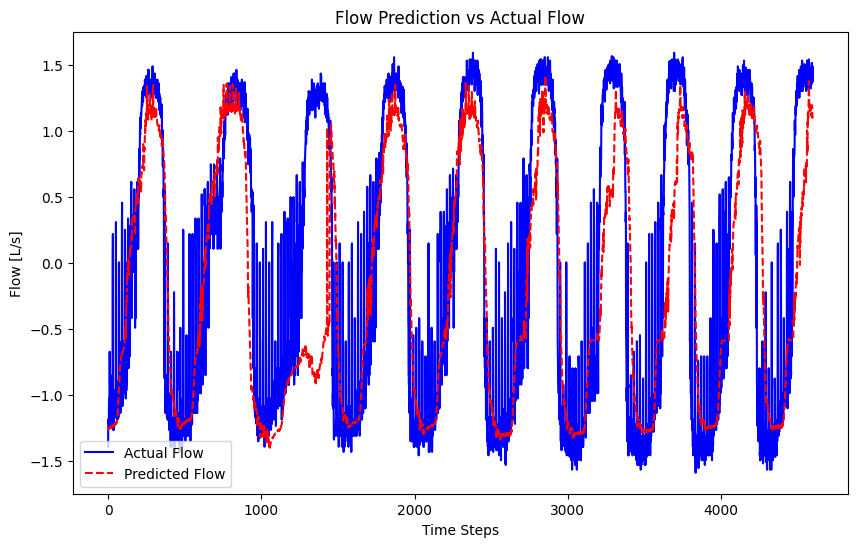

MSE 0.3379436731338501
RMSE 0.5813292295540025


In [149]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(adjusted_y_test, label='Actual Flow', color='blue')
plt.plot(predictions, label='Predicted Flow', color='red', linestyle='--')
plt.title('Flow Prediction vs Actual Flow')
plt.xlabel('Time Steps')
plt.ylabel('Flow [L/s]')
plt.legend()
plt.show()

mse = history.history['mse'][-1]

print("MSE", mse)

rmse = np.sqrt(mse)

print("RMSE", rmse)

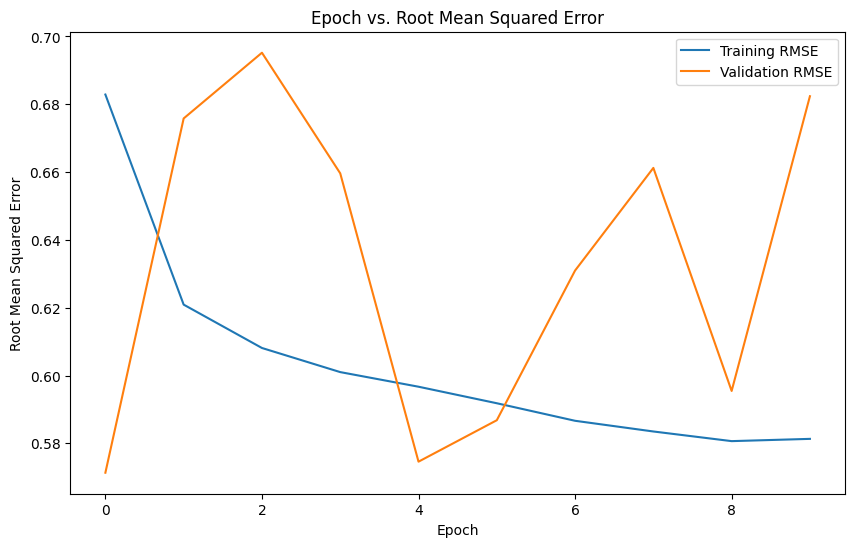

In [150]:
# Access the MSE from the history object
mse = history.history['mse']

# Calculate the RMSE by taking the square root of the MSE
rmse = np.sqrt(mse)

# Optionally, if you have validation MSE, calculate validation RMSE
val_mse = history.history.get('val_mse', None)
if val_mse is not None:
    val_rmse = np.sqrt(val_mse)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(rmse, label='Training RMSE')
if val_mse is not None:
    plt.plot(val_rmse, label='Validation RMSE')
plt.title('Epoch vs. Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()